In [1]:
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
from scipy.ndimage import gaussian_filter1d
import os
import pandas as pd
from math import isnan
import random
import glob
import sys
sys.path.append('../')
from package_global_functions import *

extSSDpath = getExternalSSDpath()
if os.path.exists(extSSDpath):
    resPath = extSSDpath + getProjectFoldername() + '/gillespie_sim_ci/results'
else:
    resPath = '/results'
    print('Forgot the SSD!!!!!')

/home/david/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def search_time_useStatDif(time, evo, statVal: float, statTime: float):
    evo_dif_to_stat = abs(evo - statVal)
    evo_rel_dif_to_stat = abs(evo - statVal)/statVal
    avgdif = np.average(evo_dif_to_stat[time >= statTime])
    # times_below_avgdif = time[evo_dif_to_stat < avgdif]
    times_rel_dif_overX = time[evo_rel_dif_to_stat >= 0.9]
    if len(times_rel_dif_overX) > 0:
        mintss = max(times_rel_dif_overX)
    else:
        mintss = 0
    # if statVal is very small do not consider the relative difference as it may rocket up many times...
    if statVal > 0.1:
        refinedTimes = time[(evo_dif_to_stat < avgdif) & (time > mintss) & (time > 2.0)]
    else:
        refinedTimes = time[(evo_dif_to_stat < avgdif) & (time > 2.0)]
    # finally...
    # initially i did this...
    # if len(refinedTimes) > 3:
    #     max_times_to_use = 3
    # else:
    #     max_times_to_use = len(refinedTimes)
    # tss = np.average(refinedTimes[0:max_times_to_use])
    # but let's only use the first time from refined times...
    tss = refinedTimes[0]
    return tss


def get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime=100.0, Nrea=100, execSim=False):
    pichain = '_'.join([str(pi) for pi in pis])
    qchain = '_'.join([str(q) for q in qs])
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    evoName = f'sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}'
    if execSim: # mandatory to execute simulations, even if evos folder already exists
        pichainExec = ','.join([str(pi) for pi in pis])
        qchainExec = ','.join([str(q) for q in qs])
        ci_kwargs_chainExec = ','.join([str(cikw) for cikw in ci_kwargs])
        simCall = f'python LES_model_gill.py -pis {pichainExec} -qs {qchainExec} -l {l} -lci {lci} -ci_kwargs {ci_kwargs_chainExec} '
        simCall += f'-N {N} -maxTime {maxTime} -Nrea {Nrea} -ic {ic} --time_evo'
        call(simCall, shell=True)
        call('tar -xzf sim_results_evos.tar.gz', shell=True)
        call(f'mv sim_results_evos {evoName}', shell=True)
        # before moving, chech if directory already exists and if so remove it:
        if os.path.exists(f'{resPath}/{evoName}'):
            call(f'rm -r {resPath}/{evoName}', shell=True)
        # input('enter ')
        call(f'mv {evoName} {resPath}/', shell=True)
    if os.path.exists(os.path.exists(evoName)): # folder exits
        evoFiles = glob.glob(f'{resPath}/{evoName}/*')
    # elif os.path.exists(f'{evoName}.tar.gz'): # compressed folder exists
    #     call(f'tar -xzf {evoName}.tar.gz', shell=True)
    #     evoFiles = glob.glob(f'{evoName}/*')
    else:
        print('No evos folder found, please execute with execSim=True')
        return
    tssMax, tssFs, statDataPool = [], {}, {}
    for k in range(len(pis)+1):
        tssFs[f'f{k}'], statDataPool[f'f{k}'] = [], []
    statTime = 0.8*maxTime
    # for f in evoFiles:
    for i in range(len(evoFiles)):
        f = f'{resPath}/{evoName}/time_evo_rea_{i}.csv'
        tevo = pd.read_csv(f)
        tssRea = []
        for k in range(len(pis)+1):
            fevo_smoothed = []
            for i in range(int(maxTime/h)):
                tmin, tmax = h*i, h*(i+1)
                fblock = np.average(tevo.query('time >= @tmin and time < @tmax')[f'f{k}'])
                fevo_smoothed.append(fblock)
            statVal = np.average(tevo.query('time > @statTime')[f'f{k}'])
            times_smooth = np.arange(0,maxTime,h)
            tss = search_time_useStatDif(times_smooth, fevo_smoothed, statVal, statTime)
            tssFs[f'f{k}'].append(tss), tssRea.append(tss)
        tssRea = [t for t in tssRea if not isnan(t)]
        if len(tssRea) > 0:
            tssRea = sorted(tssRea)
            tssMaxRea = tssRea.pop() # already removing the max time from the list...
            tssMax.append(tssMaxRea)
            # get 2000 uniformly distributed points in the stationary state
            tevoAux = tevo.query('time >= @tssMaxRea')
            len_statData = len(tevoAux)
            while len_statData < 2000 and len(tssRea) > 0:
                # print(f'could not get 2000 different ss values for {f}')
                # tssAlt = sorted(tssRea, reverse=True)[1]
                tssAlt = tssRea.pop()
                tevoAux = tevo.query('time >= @tssAlt')
            len_statData = len(tevoAux)
            if len_statData < 2000:
                print(f'could not get 2000 different ss values for {f}')
            index_statData = np.linspace(tevoAux.index[0], tevoAux.index[-1], 2000, dtype=int)
            tevoAux = tevo.query('index in @index_statData')
            for k in range(len(pis)+1):
                # statDataPool[f'f{k}'].extend(list(tevo.query('time >= @tssMaxRea')[f'f{k}'])[::3])
                statDataPool[f'f{k}'].extend(list(tevoAux[f'f{k}']))
        else:
            tssMax.append(float('nan'))
    # save data: csv? npy?
    # tssMax_df = pd.DataFrame({'tss':tssMax})
    tssFs['tssMax'] = tssMax
    tssDf = pd.DataFrame(tssFs)
    fcolumns = [col for col in tssDf.columns if col.startswith('f')]
    tssDf['tssAvg'] = tssDf[fcolumns].sum(axis=1)/3
    tssDf.to_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv', index=False)
    statDataPool = pd.DataFrame(statDataPool)
    statDataPool.to_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv', index=False)
    return tssMax, statDataPool

In [49]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
l, lci, N, maxTime, Nrea, ic = 0.2, 1.0, 1000, 400.0, 100, 'N'

h = 1.0

# ci_kwargs_list = [(0, ), (1, 0.3, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
ci_kwargs_list = [(0, ), ]
for ci_kwargs in ci_kwargs_list:
    print(f'Executing {ci_kwargs}')
    _ = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=True)

# ci_kwargs = [0, ]
# tssLin, statDataLin = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=True)

# ci_kwargs = [2, 0.3, 10.0]
# tssSig2, statDataSig2 = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=True)

# ci_kwargs = [1, 0.3, 10.0]
# tssSig1, statDataSig1 = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=True)

Executing (0,)


In [20]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
lci, N, maxTime, Nrea, ic = 1.0, 1000, 100.0, 100, 'N'
h = 1.0
ci_kwargs = [2, 0.3, 10.0]
ci_kwargs = [0, ]

for l in [0.1, 0.3, 0.6, 0.9]:
    print(l)
    _ = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=False)

0.1
0.3
0.6
0.9


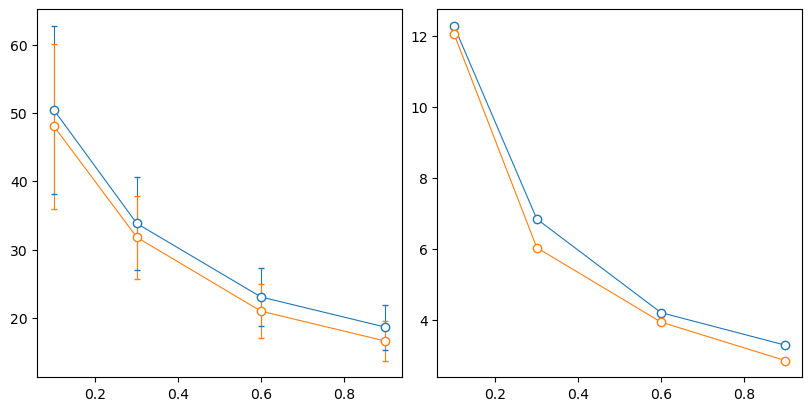

In [21]:
ls = [0.1, 0.3, 0.6, 0.9]
lci = 1.0
# ci_kwargs = [1, 0.3, 10.0]
# ci_kwargs = [0, ]
ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

# compare error in the tss with the new method that considers relative difference bumps...
fig, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
for tssPath in [f'{resPath}/old_tss/', f'{resPath}/']:
    tssEvo, tssStdEvo = [], []
    for l in ls:
        tssFile = f'{tssPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv'
        tssDf = pd.read_csv(tssFile)
        tss, tssStd = np.average(tssDf['tssAvg']), np.std(tssDf['tssAvg'])
        tssEvo.append(tss), tssStdEvo.append(tssStd)
    ax[0].errorbar(ls, tssEvo, tssStdEvo, marker='o', mfc='w', capsize=2.0, lw=0.8)
    ax[1].plot(ls, tssStdEvo, marker='o', mfc='w', lw=0.8)


# compare the error in the tss if using all times and avg, or tssMax avg
# fig, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)

# tssPath = f'{resPath}'
# tssEvo, tssStdEvo = [], []
# tssMaxEvo, tssMaxStdEvo = [], []
# for l in ls:
#     tssFile = f'{tssPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv'
#     tssDf = pd.read_csv(tssFile)
#     tss, tssStd = np.average(tssDf['tssAvg']), np.std(tssDf['tssAvg'])
#     tssEvo.append(tss), tssStdEvo.append(tssStd)
#     tssMax, tssMaxStd = np.average(tssDf['f0']), np.std(tssDf['f0'])
#     tssMaxEvo.append(tssMax), tssMaxStdEvo.append(tssMaxStd)
# ax[0].errorbar(ls, tssEvo, tssStdEvo, marker='o', mfc='w', capsize=2.0, lw=0.8)
# ax[1].plot(ls, tssStdEvo, marker='o', mfc='w', lw=0.8)
# ax[0].errorbar(ls, tssMaxEvo, tssMaxStdEvo, marker='o', mfc='w', capsize=2.0, lw=0.8)
# ax[1].plot(ls, tssMaxStdEvo, marker='o', mfc='w', lw=0.8)


### generate no cross inhibitio data also

In [31]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
N, maxTime, Nrea, ic = 1000, 100.0, 100, 'N'

lci, ci_kwargs = 0.0, [0, ] # setting linear cross inhibition but with lci=0.0 so it does not make an effect

h=1.0

# l = 0.1
# _, _ = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=False)

l = 0.3
_, _ = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=False)

l = 0.6
_, _ = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=False)

l = 0.9
_, _ = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=False)


f0        119.0
f1        127.0
f2        132.0
tssMax    132.0
tssAvg    126.0
Name: 99, dtype: float64


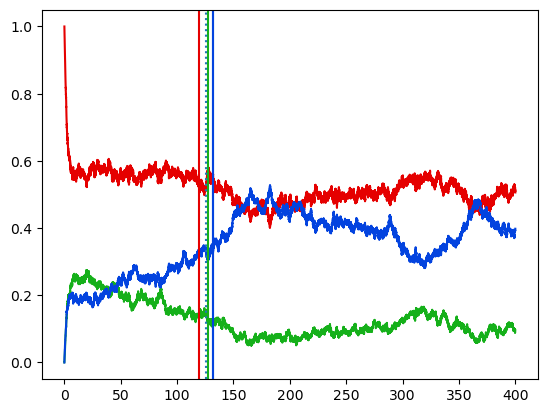

In [50]:
# shit happens in sims with these parameters:
# i = 6
# i = 38
# l, lci = 0.6, 1.0
# ci_kwargs = [1, 0.5, 500.0]

# other tests:
i = 99
l, lci = 0.2, 1.0
ci_kwargs = [0, ]
ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])


df = pd.read_csv(f'{resPath}/sim_results_evos_pis_0.1_0.1_qs_9.0_10.0_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_1000_ic_N/time_evo_rea_{i}.csv')

dftss = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_0.1_0.1_qs_9.0_10.0_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_1000_ic_N.csv')

fig, ax = plt.subplots()
ax.plot(df['time'], df['f0'], color='xkcd:red')
ax.plot(df['time'], df['f1'], color='xkcd:green')
ax.plot(df['time'], df['f2'], color='xkcd:blue')

ax.axvline(dftss['tssMax'][i])
ax.axvline(dftss['f0'][i], color='xkcd:red')
ax.axvline(dftss['f1'][i], color='xkcd:green')
ax.axvline(dftss['f2'][i], color='xkcd:blue')
ax.axvline(dftss['tssAvg'][i], ls=':')
print(dftss.iloc[i])


0.9836300000000001 0.36358382453353394
0.01636999999999998 0.4400818172602291
------
0.48999999999999994 0.026437785714285723
0.5100000000000009 0.6635178725490196
------
0.43999999999999995 0.041730329545454546
0.5600000000000004 0.6531036428571428
------


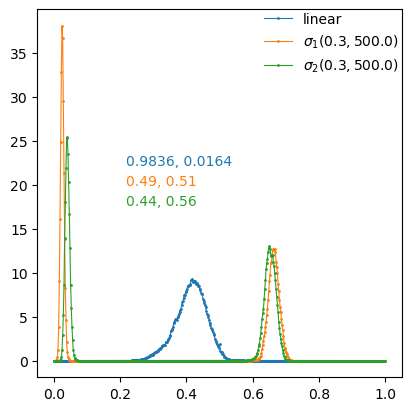

In [51]:
pis, qs, l, lci = [0.1, 0.1], [9.0, 10.0], 0.2, 1.0
# ci_kwargs_list = [[0, ], [1, 0.3, 10.0], [2, 0.3, 10.0]]
ci_kwargs_list = [[0, ], [1, 0.3, 500.0], [2, 0.3, 500.0]]
# ci_kwargs_list = [[0, ], [1, 0.5, 10.0], [2, 0.5, 10.0]]
# ci_kwargs_list = [[0, ], [1, 0.5, 500.0], [2, 0.5, 500.0]]
pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

species = []
for ci_kwargs in ci_kwargs_list:
    if len(ci_kwargs) == 1:
        species.append("linear")
    elif len(ci_kwargs) == 4 and int(ci_kwargs[3]) == 1:
        species.append(fr"$\sigma_{ci_kwargs[0]}^{{lin}} ({ci_kwargs[1]}, {ci_kwargs[2]})$")
    else:
        species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")

peaksCut = 0.4
peaksAvg = []
peaksProb = []
fig, ax = plt.subplots(1,1,figsize=(4,4), constrained_layout=True)
for i,(ci_kwargs,cilabel) in enumerate(zip(ci_kwargs_list,species)):
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    ssdata_df = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
    fdata = np.array(ssdata_df['f2'])
    hist, bin_edges = np.histogram(fdata, bins=499, range=(0,1.0), density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    binWidth = bin_edges[1]-bin_edges[0]
    ln, = ax.plot(bin_centers, hist, marker='.', ms=2, lw=0.8, label=cilabel)
    prob1, ssval1 = sum(hist[bin_centers<0.5]*binWidth), np.average(fdata[fdata<peaksCut])
    prob2, ssval2 = sum(hist[bin_centers>=0.5]*binWidth), np.average(fdata[fdata>=peaksCut])
    fig.text(0.3, 0.6-0.05*i, f'{round(prob1,4)}, {round(prob2,4)}', color=ln.get_color())
    print(prob1, ssval1)
    print(prob2, ssval2)
    print('------')
    peaksAvg.extend([ssval1, ssval2])
    peaksProb.extend([prob1, prob2])
    
fig.legend(frameon=False)


In [83]:
pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

sstimes = []
for ci_kwargs in ci_kwargs_list:
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    fname = f'tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv'
    times_df = pd.read_csv(f'{resPath}/{fname}')
    sstimes.append(np.average(times_df['tss']))

In [84]:
costF_lin = peaksAvg[1]*peaksProb[1]/np.average(sstimes[0])
costF_sig2 = peaksAvg[3]*peaksProb[3]/np.average(sstimes[1])
costF_sig1 = peaksAvg[5]*peaksProb[5]/np.average(sstimes[2])


chi = costF_sig2/costF_lin
print(chi)
chi = costF_sig1/costF_lin
print(chi)

1.4287752514776648
1.2022908099690812


# Cost function for different lambdas

In [59]:
pis, qs, lci = [0.1, 0.1], [9.0, 10.0], 1.0
N, ic = 1000, 'N'

pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

ls = [0.1, 0.2, 0.3, 0.6, 0.9]
peaksCut_ls = [0.4, 0.4, 0.4]
ci_kwargs_list = [(0, ), (1, 0.3, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]

costFuncData = {}

peaksCut_dic = {
    (0, ): [0.0, 0.0, 0.4, 0.4, 0.4],
    (1, 0.3, 10.0): [0.2, 0.35, 0.4, 0.4, 0.4],
    (2, 0.3, 10.0): [0.4, 0.4, 0.4, 0.4, 0.4],
    (1, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4],
    (2, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4]
}

for ci_kwargs in ci_kwargs_list:
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    costFuncData[ci_kwargs] = {'f2winVal':[], 'probf2winVal':[], 'tss':[], 'CF':[], 'f2winValstd':[], 'probf2winValstd':[], 'tssStd':[], 'CFstd':[]}
    for l,peaksCut in zip(ls,peaksCut_dic[ci_kwargs]):
        tssDf = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        ssDataDf = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        # time to stationary state:
        tss, tssStd = np.average(tssDf['tssAvg']), np.std(tssDf['tssAvg'])
        costFuncData[ci_kwargs]['tss'].append(tss), costFuncData[ci_kwargs]['tssStd'].append(tssStd)
        # stationary value when f2 wins:
        f2winVal, f2winValstd = np.average(ssDataDf['f2'][ssDataDf['f2']>=peaksCut]), np.std(ssDataDf['f2'][ssDataDf['f2']>=peaksCut])
        costFuncData[ci_kwargs]['f2winVal'].append(f2winVal), costFuncData[ci_kwargs]['f2winValstd'].append(f2winValstd)
        # probability to be in the f2 stationary point:
        hist, bin_edges = np.histogram(ssDataDf['f2'], bins=499, range=(0,1.0), density=True)
        bin_centers, binWidth = (bin_edges[1:] + bin_edges[:-1])/2, bin_edges[1]-bin_edges[0]
        # prob1 = sum(hist[bin_centers<0.5]*binWidth)
        probf2win = round(sum(hist[bin_centers>=peaksCut]*binWidth),8)
        probf2winStd = np.sqrt(probf2win*(1-probf2win)/len(ssDataDf['f2']))
        costFuncData[ci_kwargs]['probf2winVal'].append(probf2win), costFuncData[ci_kwargs]['probf2winValstd'].append(probf2winStd)
        # once having all the data compute the cost function value, and its std by error propagation:
        cf = probf2win*f2winVal/tss
        cfstd = (1/tss)*np.sqrt((probf2win*f2winValstd)**2+(f2winVal*probf2winStd)**2+(f2winVal*probf2win*tssStd/tss)**2)
        costFuncData[ci_kwargs]['CF'].append(cf), costFuncData[ci_kwargs]['CFstd'].append(cfstd)

# NO CROSS INHIBITION LIMIT
# costFuncData_lci0 = {'f2winVal':[], 'probf2winVal':[], 'tss':[], 'CF':[]}
# for l in ls:
#     tssDf = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_0.0_cikw_0_N_{N}_ic_{ic}.csv')
#     ssDataDf = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_0.0_cikw_0_N_{N}_ic_{ic}.csv')
#     # time to stationary state:
#     tss = np.average(tssDf['tssAvg'])
#     costFuncData_lci0['tss'].append(tss)
#     # stationary value when f2 wins:
#     f2winVal = np.average(ssDataDf['f2'])
#     costFuncData_lci0['f2winVal'].append(f2winVal)
#     # probability to be in the f2 stationary point:
#     hist, bin_edges = np.histogram(ssDataDf['f2'], bins=499, range=(0,1.0), density=True)
#     bin_centers, binWdith = (bin_edges[1:] + bin_edges[:-1])/2, bin_edges[1]-bin_edges[0]
#     # prob1 = sum(hist[bin_centers<0.5]*binWidth)
#     probf2win = sum(hist*binWidth)
#     costFuncData_lci0['probf2winVal'].append(probf2win)
#     # once having all the data compute the cost function value, and its std by error propagation:
#     cf = probf2win*f2winVal/tss
#     costFuncData_lci0['CF'].append(cf)

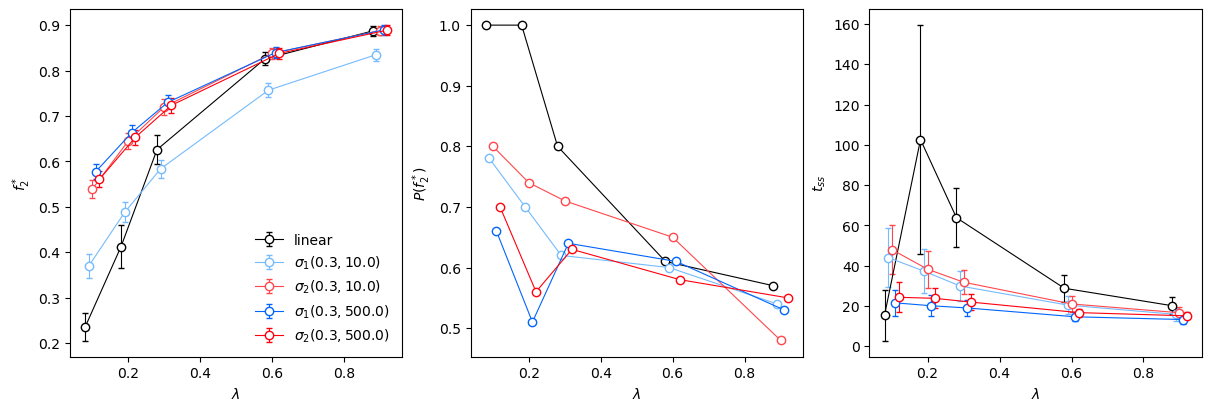

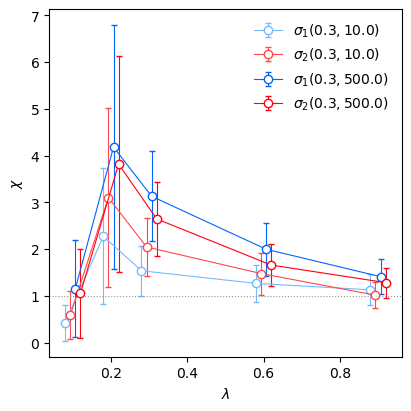

In [62]:
fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
figCF, axCF = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)

ax[0].set(xlabel='$\lambda$', ylabel='$f_2^*$')
ax[1].set(xlabel='$\lambda$', ylabel='$P(f_2^*)$')
ax[2].set(xlabel='$\lambda$', ylabel=r'$t_{ss}$')
axCF.set(xlabel='$\lambda$', ylabel='$\chi$')

species = []
for ci_kwargs in ci_kwargs_list:
    if len(ci_kwargs) == 1:
        species.append("linear")
    elif len(ci_kwargs) == 4 and int(ci_kwargs[3]) == 1:
        species.append(fr"$\sigma_{ci_kwargs[0]}^{{lin}} ({ci_kwargs[1]}, {ci_kwargs[2]})$")
    else:
        species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")


ebars = True
jitterer = np.linspace(-0.02,0.02, len(ci_kwargs_list))
# ci_kwargs_list = [(0, ), (1, 0.3, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
color_seq = ['k', 'xkcd:sky blue', 'xkcd:light red', 'xkcd:bright blue', 'xkcd:bright red']
if ebars:
    for ci_kwargs, cilabel, c, jit in zip(ci_kwargs_list, species, color_seq, jitterer):
        ax[0].errorbar(ls+jit, costFuncData[tuple(ci_kwargs)]['f2winVal'], costFuncData[tuple(ci_kwargs)]['f2winValstd'], lw=0.8, marker='o', color=c, mfc='w', label=cilabel, capsize=2.0)
        ax[1].errorbar(ls+jit, costFuncData[tuple(ci_kwargs)]['probf2winVal'], costFuncData[tuple(ci_kwargs)]['probf2winValstd'], lw=0.8, marker='o', color=c, mfc='w')
        ax[2].errorbar(ls+jit, costFuncData[tuple(ci_kwargs)]['tss'], costFuncData[tuple(ci_kwargs)]['tssStd'], lw=0.8, marker='o', color=c, mfc='w', capsize=2.0)
else:
    for ci_kwargs, cilabel, c in zip(ci_kwargs_list, species, color_seq):
        ax[0].plot(ls, costFuncData[tuple(ci_kwargs)]['f2winVal'], lw=0.8, marker='o', color=c, mfc='w', label=cilabel)
        ax[1].plot(ls, costFuncData[tuple(ci_kwargs)]['probf2winVal'], lw=0.8, marker='o', color=c, mfc='w')
        ax[2].plot(ls, costFuncData[tuple(ci_kwargs)]['tss'], lw=0.8, marker='o', color=c, mfc='w')
ax[0].legend(frameon=False)

# add no cross inhibition data...
# ax[0].plot(ls, costFuncData_lci0['f2winVal'], lw=0.9, marker='o', mfc='w', color='k', alpha=0.8, label='No CI')
# ax[1].plot(ls, costFuncData_lci0['probf2winVal'], lw=0.9, marker='o', mfc='w', color='k', alpha=0.8)
# ax[2].plot(ls, costFuncData_lci0['tss'], lw=0.9, marker='o', mfc='w', color='k', alpha=0.8)


# lets call the cost function with the greek letter psi, and the ratio with chi
jitterer = np.linspace(-0.02,0.02, len(ci_kwargs_list[1:]))
psiLin, psiLinStd = np.array(costFuncData[(0, )]['CF']), np.array(costFuncData[(0, )]['CFstd'])
for i,(ci_kwargs,cilabel,c,jit) in enumerate(zip(ci_kwargs_list[1:],species[1:],color_seq[1:], jitterer)):
    psiCI, psiCIstd = np.array(costFuncData[tuple(ci_kwargs)]['CF']), np.array(costFuncData[tuple(ci_kwargs)]['CFstd'])
    chi = psiCI/psiLin
    chiStd = (1/psiLin)*np.sqrt(psiCIstd**2 + (chi*psiLinStd)**2)
    if ebars:
        axCF.errorbar(ls+jit, chi, chiStd, marker='o', mfc='w', color=c, capsize=2.0, lw=0.8, label=cilabel) # to use the standard color sequence: color=f'C{i+1}',
    else:
        axCF.plot(ls, chi, marker='o', mfc='w', color=c, lw=0.8)

axCF.axhline(1.0, 0, 1, ls=':', lw=0.8, color='xkcd:grey')
axCF.legend(frameon=False)


fig.savefig(f'cost_func_data_pis_{pichain}_qs_{qchain}_lci_{lci}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}.png')
figCF.savefig(f'chi_pis_{pichain}_qs_{qchain}_lci_{lci}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}.png')


In [60]:
costFuncData[(0, )]

{'f2winVal': [0.23529505999999997,
  0.41263319,
  0.62588564375,
  0.8256123114754098,
  0.8870989649122807],
 'probf2winVal': [1.0, 1.0, 0.8, 0.61, 0.57],
 'tss': [15.413333333333332,
  102.61333333333334,
  63.83666666666667,
  28.80333333333333,
  20.136666666666667],
 'CF': [0.015265682958477508,
  0.00402124340566528,
  0.007843588037178214,
  0.01748490371484782,
  0.025110730508194005],
 'f2winValstd': [0.030455961807115548,
  0.04639652886180236,
  0.031231919231744083,
  0.01404809161187842,
  0.010767357051567021],
 'probf2winValstd': [0.0,
  0.0,
  0.0008944271909999158,
  0.001090642012761291,
  0.0011070230349906906],
 'tssStd': [12.76175884777991,
  56.82719849586894,
  14.523122942397753,
  6.804425847278455,
  4.36172621281478],
 'CFstd': [0.012793027834461995,
  0.0022723993308539476,
  0.0018268918936360523,
  0.004141407472406307,
  0.005447890223103485]}

In [56]:
psiLinStd

array([0.01279303,        nan, 0.00182689, 0.00414141, 0.00544789])